<a href="https://colab.research.google.com/github/open-mmlab/mmaction2/blob/master/demo/mmaction2_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:

# Install some optional requirements
# !pip install -r requirements/optional.txt

In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
import decord
import pickle

1.7.0+cu110 True
0.12.0
11.0
GCC 7.5


In [4]:
cd ..

/home/actrec/.virtualenvs/mmaction/mmaction2


In [1]:
ls

checkpoints/  demo/        LICENSE              README.md         setup.cfg
childact-mm/  docker/      mmaction/            README_zh-CN.md   setup.py
configs/      docs/        mmaction2.egg-info/  requirements/     tests/
data/         docs_zh_CN/  my-mmaction.ipynb    requirements.txt  tools/


# TSN 90.48% 

In [11]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

In [25]:
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/   .pth \
#       -O checkpoints/db3c461.pth

--2021-03-22 01:46:07--  https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics600_rgb/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99220779 (95M) [application/octet-stream]
Saving to: ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’

checkpoints/tsn_r50 100%[===================>]  94,62M  10,5MB/s    in 11s     

2021-03-22 01:46:22 (8,61 MB/s) - ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’ saved [99220779/99220779]



In [12]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
# cfg.load_from = './checkpoints/best_top1_acc_epoch_5.pth'
cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-mm/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 32
cfg.optimizer.lr = 0.0001
# cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 30

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 10

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNet',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False),
    cls_head=dict(
        type='TSNHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.4,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(type='SGD', lr=0.0001, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dict(policy='step', step=[40, 80])
total_epochs = 30
checkpoint_config = dict(interval=2)
log_config = dict(interval=10, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = None
resume_from = './childact-mm/latest.pth'
workflow = [('train', 1)]
dataset_type = 'VideoDataset'
data_root = 'data/childact_split/train/'
data_root_val = 'dat

### Train a new recognizer

Finally, lets initialize the dataset and recognizer, then train a new recognizer!

In [13]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-22 16:04:14,045 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight'}


Use load_from_torchvision loader


2021-03-22 16:04:16,416 - mmaction - INFO - load checkpoint from ./childact-mm/latest.pth
2021-03-22 16:04:16,417 - mmaction - INFO - Use load_from_local loader
2021-03-22 16:04:16,539 - mmaction - INFO - resumed epoch 12, iter 561
2021-03-22 16:04:16,541 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-mm
2021-03-22 16:04:16,542 - mmaction - INFO - workflow: [('train', 1)], max: 30 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
2021-03-22 16:05:56,931 - mmaction - INFO - Epoch [13][10/33]	lr: 5.000e-04, eta: 1:10:06, time: 10.039, data_time: 9.158, memory: 21448, top1_acc: 0.9375, top5_acc: 1.0000, loss_cls: 0.2199, loss: 0.2199, grad_norm: 3.0833
2021-03-22 16:07:05,519 - mmaction - INFO - Epoch [13][20/33]	lr: 5.000e-04, eta: 0:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 35s, ETA:     0s

2021-03-22 16:19:08,703 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 16:19:08,705 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-22 16:19:08,706 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 16:19:08,707 - mmaction - INFO - 
mean_acc	0.8492
2021-03-22 16:19:09,000 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-03-22 16:19:09,001 - mmaction - INFO - Best top1_acc is 0.8492 at 15 epoch.
2021-03-22 16:19:09,002 - mmaction - INFO - Epoch(val) [15][33]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-22 16:20:54,290 - mmaction - INFO - Epoch [16][10/33]	lr: 5.000e-04, eta: 0:44:12, time: 10.529, data_time: 9.656, memory: 21448, top1_acc: 0.8656, top5_acc: 1.0000, loss_cls: 0.3135, loss: 0.3135, grad_norm: 5.0392
2021-03-22 16:22:01,583 - mmaction - INFO - Epoch [16][20/33]	lr: 5.000e-04, eta: 0:42:08, time: 6.729, data_time: 5.830, memory: 21448, top1_acc: 0.9094, top5_acc: 0.9969,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-22 16:43:42,967 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 16:43:42,969 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-22 16:43:42,970 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 16:43:42,971 - mmaction - INFO - 
mean_acc	0.8571
2021-03-22 16:43:43,294 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-03-22 16:43:43,295 - mmaction - INFO - Best top1_acc is 0.8571 at 20 epoch.
2021-03-22 16:43:43,296 - mmaction - INFO - Epoch(val) [20][33]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-22 16:45:20,813 - mmaction - INFO - Epoch [21][10/33]	lr: 5.000e-04, eta: 0:21:02, time: 9.751, data_time: 8.872, memory: 21448, top1_acc: 0.8875, top5_acc: 1.0000, loss_cls: 0.2959, loss: 0.2959, grad_norm: 5.2473
2021-03-22 16:46:30,437 - mmaction - INFO - Epoch [21][20/33]	lr: 5.000e-04, eta: 0:19:34, time: 6.962, data_time: 6.085, memory: 21448, top1_acc: 0.8875, top5_acc: 1.0000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-22 17:08:12,494 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 17:08:12,496 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-22 17:08:12,496 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 17:08:12,497 - mmaction - INFO - 
mean_acc	0.8571
2021-03-22 17:08:12,497 - mmaction - INFO - Epoch(val) [25][33]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-22 17:09:53,555 - mmaction - INFO - Epoch [26][10/33]	lr: 5.000e-04, eta: -1 day, 23:58:40, time: 10.105, data_time: 9.229, memory: 21448, top1_acc: 0.8969, top5_acc: 1.0000, loss_cls: 0.2787, loss: 0.2787, grad_norm: 4.8332
2021-03-22 17:11:02,020 - mmaction - INFO - Epoch [26][20/33]	lr: 5.000e-04, eta: -1 day, 23:57:19, time: 6.847, data_time: 5.975, memory: 21448, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2513, loss: 0.2513, grad_norm: 5.1216
2021-03-22 17:12:38,741 - mmaction - INFO - Epoch [26][30/33]	lr: 5.000e-04, eta: -1 day, 23:55:57, time: 9.672, dat

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-22 17:32:40,845 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-22 17:32:40,847 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-03-22 17:32:40,848 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-22 17:32:40,849 - mmaction - INFO - 
mean_acc	0.8413
2021-03-22 17:32:40,850 - mmaction - INFO - Epoch(val) [30][33]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413


## Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [14]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=16,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.1 task/s, elapsed: 59s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9048
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9048
top1_acc: 0.9048
top5_acc: 1.0000
mean_class_accuracy: 0.9048


# SlowFast 91.27%

In [2]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth \
      -O checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth

--2021-03-22 18:16:35--  https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138274276 (132M) [application/octet-stream]
Saving to: ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’

checkpoints/slowfas 100%[===================>] 131,87M  6,72MB/s    in 17s     

2021-03-22 18:16:55 (7,79 MB/s) - ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’ saved [138274276/138274276]



In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb.py')

In [3]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './childact-checkpoints/childact-slowfast2/best_top1_acc_epoch_5.pth'
# cfg.resume_from = './childact-checkpoints/childact-slowfast/best_top1_acc_epoch_50.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-slowfast3/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
# cfg.data.workers_per_gpu = 4
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 5

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
# print(f'Config:\n{cfg.pretty_text}')


In [9]:
# del cfg.optimizer['momentum']

### Train a new recognizer

Finally, lets initialize the dataset and recognizer, then train a new recognizer!

In [4]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-24 13:17:39,463 - mmaction - INFO - load checkpoint from ./childact-checkpoints/childact-slowfast2/best_top1_acc_epoch_5.pth
2021-03-24 13:17:39,464 - mmaction - INFO - Use load_from_local loader
2021-03-24 13:17:40,173 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-slowfast3
2021-03-24 13:17:40,174 - mmaction - INFO - workflow: [('train', 1)], max: 5 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
/home/actrec/.virtualenvs/mmaction/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed outp

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.3 task/s, elapsed: 20s, ETA:     0s

2021-03-24 13:30:14,656 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 13:30:14,658 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-24 13:30:14,658 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 13:30:14,659 - mmaction - INFO - 
mean_acc	0.8571
2021-03-24 13:30:15,020 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-24 13:30:15,021 - mmaction - INFO - Best top1_acc is 0.8571 at 5 epoch.
2021-03-24 13:30:15,021 - mmaction - INFO - Epoch(val) [5][66]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571


In [5]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
import gc
# gc.enable()
gc.collect()

0

## Test the trained recognizer

After finetuning the recognizer, let's check the prediction results!

In [31]:
from mmaction.apis import single_gpu_test, inference_recognizer, init_recognizer
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

In [5]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# checkpoint = './childact-checkpoints/childact-slowfast/best_top1_acc_epoch_50.pth'
# modelt = init_recognizer(cfg, checkpoint, device='cuda:0')
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=2,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.4 task/s, elapsed: 303s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9127
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9127
top1_acc: 0.9127
top5_acc: 1.0000
mean_class_accuracy: 0.9127


In [ ]:
# mmaction.core.evaluation.confusion_matrix()
# gt_confusion_matrix()

# R(2+1)D 59.52%

In [6]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth \
      -O checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth

--2021-03-24 13:44:27--  https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255320099 (243M) [application/octet-stream]
Saving to: ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’

checkpoints/r2plus1 100%[===================>] 243,49M  6,98MB/s    in 32s     

2021-03-24 13:45:05 (7,72 MB/s) - ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’ saved [255320099/255320099]



In [5]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb.py')

In [6]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth'
# cfg.resume_from = './childact-checkpoints/childact-r2plus1d/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-r2plus1d-2'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 25

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
cfg.model.backbone.norm_cfg.type = 'BN3d'
# cfg.model.cls_head.type = "TSNHead"
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet2Plus1d',
        depth=34,
        pretrained=None,
        pretrained2d=False,
        norm_eval=False,
        conv_cfg=dict(type='Conv2plus1d'),
        norm_cfg=dict(type='BN3d', requires_grad=True, eps=0.001),
        conv1_kernel=(3, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(1, 1, 1, 1),
        spatial_strides=(1, 2, 2, 2),
        temporal_strides=(1, 2, 2, 2),
        zero_init_residual=False,
        act_cfg=dict(type='ReLU')),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=512,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=4)
log_config = dict(interval=25, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/r2plus1d_r34_video_8

In [7]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 11:23:21,172 - mmaction - INFO - load checkpoint from ./checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
2021-03-25 11:23:21,173 - mmaction - INFO - Use load_from_local loader
2021-03-25 11:23:21,319 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 512]) from checkpoint, the shape in current model is torch.Size([7, 512]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-25 11:23:21,323 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-r2plus1d-2
2021-03-25 11:23:21,324 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
2021-03-25 11:24:08,150 - mmaction - INFO - Epoch [1][25/66]	lr: 2.014e-01, eta: 1:44:17,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.2 task/s, elapsed: 15s, ETA:     0s

2021-03-25 11:32:49,233 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 11:32:49,235 - mmaction - INFO - 
top1_acc	0.3333
top5_acc	1.0000
2021-03-25 11:32:49,236 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 11:32:49,237 - mmaction - INFO - 
mean_acc	0.3333
2021-03-25 11:32:50,071 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-25 11:32:50,072 - mmaction - INFO - Best top1_acc is 0.3333 at 5 epoch.
2021-03-25 11:32:50,073 - mmaction - INFO - Epoch(val) [5][66]	top1_acc: 0.3333, top5_acc: 1.0000, mean_class_accuracy: 0.3333
2021-03-25 11:33:34,649 - mmaction - INFO - Epoch [6][25/66]	lr: 4.901e-01, eta: 1:07:19, time: 1.783, data_time: 1.102, memory: 10924, top1_acc: 0.2500, top5_acc: 0.9500, loss_cls: 1.5939, loss: 1.5939, grad_norm: 0.4893
2021-03-25 11:34:17,280 - mmaction - INFO - Epoch [6][50/66]	lr: 5.298e-01, eta: 1:07:57, time: 1.705, data_time: 1.021, memory: 10924, top1_acc: 0.2550, top5_acc: 0.9350, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-25 11:42:12,199 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 11:42:12,202 - mmaction - INFO - 
top1_acc	0.2698
top5_acc	0.9921
2021-03-25 11:42:12,203 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 11:42:12,204 - mmaction - INFO - 
mean_acc	0.2698
2021-03-25 11:42:12,205 - mmaction - INFO - Epoch(val) [10][66]	top1_acc: 0.2698, top5_acc: 0.9921, mean_class_accuracy: 0.2698
2021-03-25 11:43:00,088 - mmaction - INFO - Epoch [11][25/66]	lr: 1.123e+00, eta: 0:59:10, time: 1.915, data_time: 1.231, memory: 10924, top1_acc: 0.2625, top5_acc: 0.9075, loss_cls: 1.9964, loss: 1.9964, grad_norm: 0.7338
2021-03-25 11:43:36,159 - mmaction - INFO - Epoch [11][50/66]	lr: 1.176e+00, eta: 0:58:48, time: 1.443, data_time: 0.760, memory: 10924, top1_acc: 0.2050, top5_acc: 0.9025, loss_cls: 1.9441, loss: 1.9441, grad_norm: 0.6621
2021-03-25 11:44:46,809 - mmaction - INFO - Epoch [12][25/66]	lr: 1.261e+00, eta: 0:57:31, time: 1.922, data_time: 1.238, memory: 10924

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.4 task/s, elapsed: 15s, ETA:     0s

2021-03-25 11:51:23,839 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 11:51:23,841 - mmaction - INFO - 
top1_acc	0.3016
top5_acc	0.8571
2021-03-25 11:51:23,841 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 11:51:23,843 - mmaction - INFO - 
mean_acc	0.3016
2021-03-25 11:51:23,844 - mmaction - INFO - Epoch(val) [15][66]	top1_acc: 0.3016, top5_acc: 0.8571, mean_class_accuracy: 0.3016
2021-03-25 11:52:07,919 - mmaction - INFO - Epoch [16][25/66]	lr: 1.743e+00, eta: 0:51:04, time: 1.763, data_time: 1.083, memory: 10924, top1_acc: 0.2350, top5_acc: 0.9025, loss_cls: 1.8946, loss: 1.8946, grad_norm: 0.5508
2021-03-25 11:52:49,289 - mmaction - INFO - Epoch [16][50/66]	lr: 1.779e+00, eta: 0:50:51, time: 1.655, data_time: 0.973, memory: 10924, top1_acc: 0.3075, top5_acc: 0.8850, loss_cls: 2.0915, loss: 2.0915, grad_norm: 0.7043
2021-03-25 11:53:09,907 - mmaction - INFO - Saving checkpoint at 16 epochs
2021-03-25 11:53:57,810 - mmaction - INFO - Epoch [17][25/66

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-25 12:00:47,178 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:00:47,180 - mmaction - INFO - 
top1_acc	0.1508
top5_acc	0.7143
2021-03-25 12:00:47,181 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:00:47,182 - mmaction - INFO - 
mean_acc	0.1508
2021-03-25 12:00:47,183 - mmaction - INFO - Epoch(val) [20][66]	top1_acc: 0.1508, top5_acc: 0.7143, mean_class_accuracy: 0.1508
2021-03-25 12:01:35,442 - mmaction - INFO - Epoch [21][25/66]	lr: 2.000e+00, eta: 0:44:02, time: 1.930, data_time: 1.244, memory: 10924, top1_acc: 0.1975, top5_acc: 0.7975, loss_cls: 2.0711, loss: 2.0711, grad_norm: 0.7345
2021-03-25 12:02:14,519 - mmaction - INFO - Epoch [21][50/66]	lr: 1.999e+00, eta: 0:43:39, time: 1.563, data_time: 0.854, memory: 10924, top1_acc: 0.2025, top5_acc: 0.8775, loss_cls: 1.9971, loss: 1.9971, grad_norm: 0.5171


KeyboardInterrupt: 

In [30]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [34]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader, load_annotations, build_dataset
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.7 task/s, elapsed: 180s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5952
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.5952
top1_acc: 0.5952
top5_acc: 1.0000
mean_class_accuracy: 0.5952


<AxesSubplot:>

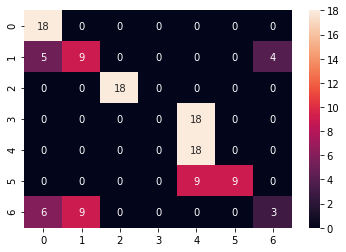

In [73]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True)

# TSM 93.65%

In [3]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth \
      -O checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth

--2021-03-24 19:15:04--  https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97579687 (93M) [application/octet-stream]
Saving to: ‘checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth’

checkpoints/tsm_r50 100%[===================>]  93,06M  8,72MB/s    in 12s     

2021-03-24 19:15:20 (7,71 MB/s) - ‘checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth’ saved [97579687/97579687]



In [9]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsm/tsm_r50_video_1x1x8_50e_kinetics400_rgb.py')

In [10]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-tsm'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 25

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNetTSM',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False,
        shift_div=8),
    cls_head=dict(
        type='TSMHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.5,
        init_std=0.001,
        is_shift=True),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
optimizer = dict(
    type='SGD',
    constructor='TSMOptimizerConstructor',
    paramwise_cfg=dict(fc_lr5=True),
    lr=0.02,
    weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=20, norm_type=2))
lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 0.0001),
    cyclic_times=1,
    step_ratio_up=0.4)
total_epochs = 51
checkpoint_config = dict(interval=4)
log_config = dict(interval=25, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
l

In [11]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-24 21:03:31,550 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias'}


Use load_from_torchvision loader


2021-03-24 21:03:33,980 - mmaction - INFO - load checkpoint from checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth
2021-03-24 21:03:33,982 - mmaction - INFO - Use load_from_local loader
2021-03-24 21:03:34,081 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-24 21:03:34,086 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-tsm
2021-03-24 21:03:34,087 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 21:26:56,186 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 21:26:56,188 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-24 21:26:56,188 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 21:26:56,190 - mmaction - INFO - 
mean_acc	0.8016
2021-03-24 21:26:56,341 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-24 21:26:56,342 - mmaction - INFO - Best top1_acc is 0.8016 at 5 epoch.
2021-03-24 21:26:56,343 - mmaction - INFO - Epoch(val) [5][44]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-24 21:29:50,484 - mmaction - INFO - Epoch [6][25/44]	lr: 5.091e-02, eta: 2:18:31, time: 6.965, data_time: 5.991, memory: 20204, top1_acc: 0.8633, top5_acc: 0.9983, loss_cls: 0.3578, loss: 0.3578, grad_norm: 4.3697
2021-03-24 21:34:28,680 - mmaction - INFO - Epoch [7][25/44]	lr: 6.203e-02, eta: 2:15:02, time: 7.168, data_time: 6.192, memory: 20204, top1_acc: 0.8700, top5_acc: 0.9983, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 21:50:22,735 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 21:50:22,737 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-24 21:50:22,737 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 21:50:22,739 - mmaction - INFO - 
mean_acc	0.8492
2021-03-24 21:50:22,912 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-24 21:50:22,912 - mmaction - INFO - Best top1_acc is 0.8492 at 10 epoch.
2021-03-24 21:50:22,913 - mmaction - INFO - Epoch(val) [10][44]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-24 21:53:16,024 - mmaction - INFO - Epoch [11][25/44]	lr: 1.149e-01, eta: 1:59:43, time: 6.924, data_time: 5.948, memory: 20204, top1_acc: 0.8817, top5_acc: 1.0000, loss_cls: 0.3227, loss: 0.3227, grad_norm: 2.9154
2021-03-24 21:57:42,847 - mmaction - INFO - Epoch [12][25/44]	lr: 1.286e-01, eta: 1:56:20, time: 6.806, data_time: 5.830, memory: 20204, top1_acc: 0.8550, top5_acc: 0.9983, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 22:13:51,448 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 22:13:51,450 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 22:13:51,451 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 22:13:51,452 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 22:13:51,453 - mmaction - INFO - Epoch(val) [15][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 22:16:43,943 - mmaction - INFO - Epoch [16][25/44]	lr: 1.761e-01, eta: 1:43:45, time: 6.899, data_time: 5.905, memory: 20204, top1_acc: 0.8417, top5_acc: 1.0000, loss_cls: 0.3540, loss: 0.3540, grad_norm: 2.6687
2021-03-24 22:18:21,773 - mmaction - INFO - Saving checkpoint at 16 epochs
2021-03-24 22:21:12,732 - mmaction - INFO - Epoch [17][25/44]	lr: 1.847e-01, eta: 1:40:39, time: 6.831, data_time: 5.806, memory: 20204, top1_acc: 0.8600, top5_acc: 1.0000, loss_cls: 0.3870, loss: 0.3870, grad_norm: 3.2032
2021-03-24 22:25:49,296 - mmaction - INFO - Epoch [18][25/44

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 22:37:17,321 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 22:37:17,323 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 22:37:17,323 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 22:37:17,325 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 22:37:17,326 - mmaction - INFO - Epoch(val) [20][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 22:40:03,624 - mmaction - INFO - Epoch [21][25/44]	lr: 2.000e-01, eta: 1:28:33, time: 6.652, data_time: 5.674, memory: 20204, top1_acc: 0.8833, top5_acc: 1.0000, loss_cls: 0.2851, loss: 0.2851, grad_norm: 1.9111
2021-03-24 22:44:38,747 - mmaction - INFO - Epoch [22][25/44]	lr: 1.993e-01, eta: 1:25:35, time: 6.870, data_time: 5.893, memory: 20204, top1_acc: 0.8867, top5_acc: 1.0000, loss_cls: 0.2601, loss: 0.2601, grad_norm: 2.1638
2021-03-24 22:49:22,392 - mmaction - INFO - Epoch [23][25/44]	lr: 1.976e-01, eta: 1:22:50, time: 7.289, data_time: 6.287, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 23:00:59,644 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:00:59,647 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-03-24 23:00:59,648 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:00:59,651 - mmaction - INFO - 
mean_acc	0.8175
2021-03-24 23:00:59,652 - mmaction - INFO - Epoch(val) [25][44]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-03-24 23:03:51,401 - mmaction - INFO - Epoch [26][25/44]	lr: 1.863e-01, eta: 1:14:06, time: 6.870, data_time: 5.887, memory: 20204, top1_acc: 0.8933, top5_acc: 1.0000, loss_cls: 0.2764, loss: 0.2764, grad_norm: 2.1380
2021-03-24 23:08:27,656 - mmaction - INFO - Epoch [27][25/44]	lr: 1.807e-01, eta: 1:11:07, time: 6.820, data_time: 5.837, memory: 20204, top1_acc: 0.8933, top5_acc: 0.9983, loss_cls: 0.2690, loss: 0.2690, grad_norm: 2.0275
2021-03-24 23:12:53,090 - mmaction - INFO - Epoch [28][25/44]	lr: 1.742e-01, eta: 1:08:04, time: 6.593, data_time: 5.600, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-24 23:24:46,975 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:24:46,977 - mmaction - INFO - 
top1_acc	0.8730
top5_acc	1.0000
2021-03-24 23:24:46,977 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:24:46,979 - mmaction - INFO - 
mean_acc	0.8730
2021-03-24 23:24:47,130 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-03-24 23:24:47,131 - mmaction - INFO - Best top1_acc is 0.8730 at 30 epoch.
2021-03-24 23:24:47,132 - mmaction - INFO - Epoch(val) [30][44]	top1_acc: 0.8730, top5_acc: 1.0000, mean_class_accuracy: 0.8730
2021-03-24 23:27:36,817 - mmaction - INFO - Epoch [31][25/44]	lr: 1.504e-01, eta: 0:59:15, time: 6.787, data_time: 5.808, memory: 20204, top1_acc: 0.9150, top5_acc: 0.9983, loss_cls: 0.2196, loss: 0.2196, grad_norm: 1.8701
2021-03-24 23:32:14,860 - mmaction - INFO - Epoch [32][25/44]	lr: 1.413e-01, eta: 0:56:22, time: 7.025, data_time: 6.044, memory: 20204, top1_acc: 0.9217, top5_acc: 1.0000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-24 23:48:22,662 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:48:22,664 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 23:48:22,665 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:48:22,667 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 23:48:22,668 - mmaction - INFO - Epoch(val) [35][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 23:51:14,376 - mmaction - INFO - Epoch [36][25/44]	lr: 1.015e-01, eta: 0:44:36, time: 6.868, data_time: 5.877, memory: 20204, top1_acc: 0.9167, top5_acc: 1.0000, loss_cls: 0.1841, loss: 0.1841, grad_norm: 2.0693
2021-03-24 23:52:51,813 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-03-24 23:55:40,270 - mmaction - INFO - Epoch [37][25/44]	lr: 9.127e-02, eta: 0:41:41, time: 6.732, data_time: 5.754, memory: 20204, top1_acc: 0.9533, top5_acc: 1.0000, loss_cls: 0.1247, loss: 0.1247, grad_norm: 1.3474
2021-03-25 00:00:14,754 - mmaction - INFO - Epoch [38][25/44

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-25 00:11:59,894 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 00:11:59,896 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-03-25 00:11:59,897 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 00:11:59,898 - mmaction - INFO - 
mean_acc	0.9206
2021-03-25 00:12:00,066 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-25 00:12:00,067 - mmaction - INFO - Best top1_acc is 0.9206 at 40 epoch.
2021-03-25 00:12:00,068 - mmaction - INFO - Epoch(val) [40][44]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-03-25 00:15:02,371 - mmaction - INFO - Epoch [41][25/44]	lr: 5.224e-02, eta: 0:30:08, time: 7.292, data_time: 6.300, memory: 20204, top1_acc: 0.9417, top5_acc: 1.0000, loss_cls: 0.1471, loss: 0.1471, grad_norm: 1.4060
2021-03-25 00:19:40,726 - mmaction - INFO - Epoch [42][25/44]	lr: 4.349e-02, eta: 0:27:16, time: 7.081, data_time: 6.099, memory: 20204, top1_acc: 0.9417, top5_acc: 0.9983, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-25 00:39:22,798 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 00:39:22,800 - mmaction - INFO - 
top1_acc	0.9048
top5_acc	1.0000
2021-03-25 00:39:22,800 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 00:39:22,802 - mmaction - INFO - 
mean_acc	0.9048
2021-03-25 00:39:22,803 - mmaction - INFO - Epoch(val) [45][44]	top1_acc: 0.9048, top5_acc: 1.0000, mean_class_accuracy: 0.9048
2021-03-25 00:42:20,754 - mmaction - INFO - Epoch [46][25/44]	lr: 1.526e-02, eta: 0:15:56, time: 7.118, data_time: 6.136, memory: 20204, top1_acc: 0.9550, top5_acc: 1.0000, loss_cls: 0.1165, loss: 0.1165, grad_norm: 1.5267
2021-03-25 00:46:57,192 - mmaction - INFO - Epoch [47][25/44]	lr: 1.027e-02, eta: 0:12:59, time: 7.019, data_time: 6.046, memory: 20204, top1_acc: 0.9633, top5_acc: 1.0000, loss_cls: 0.0944, loss: 0.0944, grad_norm: 1.2650
2021-03-25 00:51:21,230 - mmaction - INFO - Epoch [48][25/44]	lr: 6.220e-03, eta: 0:10:03, time: 6.794, data_time: 5.818, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.3 task/s, elapsed: 98s, ETA:     0s

2021-03-25 01:03:51,321 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 01:03:51,323 - mmaction - INFO - 
top1_acc	0.9127
top5_acc	1.0000
2021-03-25 01:03:51,324 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 01:03:51,326 - mmaction - INFO - 
mean_acc	0.9127
2021-03-25 01:03:51,327 - mmaction - INFO - Epoch(val) [50][44]	top1_acc: 0.9127, top5_acc: 1.0000, mean_class_accuracy: 0.9127
2021-03-25 01:06:43,848 - mmaction - INFO - Epoch [51][25/44]	lr: 1.108e-04, eta: 0:01:15, time: 6.901, data_time: 5.915, memory: 20204, top1_acc: 0.9583, top5_acc: 1.0000, loss_cls: 0.0970, loss: 0.0970, grad_norm: 1.2868


In [16]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.1 task/s, elapsed: 120s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

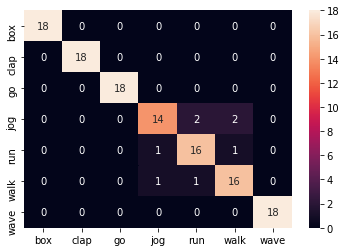

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )